In [1]:
%matplotlib inline 
# plots graphs within the notebook
%config InlineBackend.figure_format='svg' # not sure what this does, may be default images to svg format

from IPython.display import Image
from IPython.display import clear_output

from IPython.core.display import HTML
def header(text):
    raw_html = '<h4>' + str(text) + '</h4>'
    return raw_html

def box(text):
    raw_html = '<div style="border:1px dotted black;padding:2em;">'+str(text)+'</div>'
    return HTML(raw_html)

def nobox(text):
    raw_html = '<p>'+str(text)+'</p>'
    return HTML(raw_html)

def addContent(raw_html):
    global htmlContent
    htmlContent += raw_html
    
class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0} width={1[0]} height={1[1]}></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)
    
font = {'family' : 'serif',
        'color'  : 'black',
        'weight' : 'normal',
        'size'   : 18,
        }



In [2]:
PDF('figures/Staggered-grid-2D.pdf',size=(600,500))

Figure 1. Sketch of a cell (top left) with the horizontal (red) and vertical (green) velocity nodes and the cell-centered node (blue). Definition of the normal vector to "surface" (segment) $S_{i+\frac{1}{2},j}$ and $S_{i,j+\frac{1}{2}}$ (top right). Sketch of uniform grid (bottom).

<h1>Derivation of 1D Transport Equation</h1>

<h2>1D Transport Without Diffusion</h2>

Consider a small control surface (cell) of dimensions $\Delta x\times\Delta y$ within which, we know the velocities on the surfaces $u_{i\pm\frac{1}{2},j}$ and $v_{i,j\pm\frac{1}{2}}$ and a quantity $\phi_{i,j}$ at the center of the cell. This quantity may be temperature, or the concentration of chemical specie. The variation in time of $\phi$ within the cell is equal to the amount of $\phi$ that is flowing in and out of the cell through the boundaries of cell. The velocity vector is defined as

$$
\vec{u}=u\vec{e}_x+v\vec{e}_y
$$

The fluxes of $\phi$ across the right-hand-side and left-hand-side vertical boundaries are, respectively:

$$
\int_{S_{i+1/2,j}}\phi(\vec{u}_{i+\frac{1}{2},j}\cdot\vec{n}_{i+\frac{1}{2},j})dy\text{ and }\int_{S_{i-1/2,j}}\phi(\vec{u}_{i-\frac{1}{2},j}\cdot\vec{n}_{i+\frac{1}{2},j})dy
$$

In the configuration depicted in Figure 1, the mass or heat variation is equal to the flux of $\phi$ entering the cell minus the flux exiting the cell, or:
$$
-\phi_{i+\frac{1}{2},j}u_{i+\frac{1}{2},j}\Delta y + \phi_{i-\frac{1}{2},j}u_{i-\frac{1}{2},j}\Delta y \text{, when $\Delta y\rightarrow 0$}
$$

Assuming that there is no vertical velocity ($v=0$), this sum is equal to the variation of $\phi$ within the cell,

$$
\frac{\partial}{\partial t}\iint_{V_{i,j}}\phi dxdy\approx\frac{\partial \phi_{i,j}}{\partial t}\Delta x\Delta y \text{, when $\Delta x\rightarrow 0$ and $\Delta y\rightarrow 0$}
$$

yielding

$$
\frac{\partial \phi_{i,j}}{\partial t}\Delta x\Delta y=-\phi_{i+\frac{1}{2},j}u_{i+\frac{1}{2},j}\Delta y + \phi_{i-\frac{1}{2},j}u_{i-\frac{1}{2},j}\Delta y\;,
$$

reducing to

$$
\frac{\partial \phi_{i,j}}{\partial t}=-\frac{\phi_{i+\frac{1}{2},j}u_{i+\frac{1}{2},j} - \phi_{i-\frac{1}{2},j}u_{i-\frac{1}{2},j}}{\Delta x}\;.
$$

In the limit of $\Delta x\rightarrow 0$, we obtain the conservative form of the pure advection equation:
<p class='alert alert-danger'>
$$
\frac{\partial \phi}{\partial t}+\frac{\partial u\phi}{\partial x}=0
$$
</p>

<h2>1.2 Coding the Pure Advection Equation</h2>
The following takes you through the steps to solve numerically the pure advection equation with python. The boundary conditions are (all variables are non-dimensional):
<ol>
<li> Length of the domain: $0\leq x\leq L$ and $L=8\pi$ </li>
<li> Constant velocity $u_0=1$
<li> Inlet $x=0$ and outlet $x=L$: zero-flux variation (in space)</li>
<li> Initial condition: 
$$\phi(x,t=0)=\begin{cases}
1+\cos\left(x-\frac{L}{2}\right)&,\text{ for }\left\vert x-\frac{L}{2}\right\vert\leq\pi\\
0&,\text{ for }\left\vert x-\frac{L}{2}\right\vert>\pi
\end{cases}
$$
</li>
</ol>

Here you will <b>discretize</b> your domain in $N$ small control volumes, such that the size of each control volume is
<p class='alert alert-danger'>
$$
\Delta x = \frac{L}{N}
$$
</p>
You will simulate the system defined so far of a time $T$, to be decided, discretized by small time-steps
<p class='alert alert-danger'>
$$
\Delta t = \frac{T}{N_t}
$$
</p>

We adopt the following index convention:
<ul>
<li> Each cell is labeled by a unique integer $i$ with $i\in[0,N-1]$. This is a python convention that vector and matrices start with index 0, instead of 1 for matlab.</li>
<li> A variable defined at the center of cell $i$ is noted with the subscript $i$: $\phi_i$.</li>
<li> A variable defined at the surface of cell $i$ is noted with the subscript $i\pm1/2$: $\phi_{i\pm 1/2}$</li>
<li> The solution $\phi(x_i,t_n)$, where
$$
x_i = i\Delta x\text{ with $x\in[0,N-1]$, and }t_n=n\Delta t\text{ with $n\in[0,N_t]$,}
$$</li>
is noted $\phi_i^n$.
</ul>
At first we will try to solve the advection equation with the following discretization:
$$
\frac{\phi_i^{n+1}-\phi_i^n}{\Delta t}=-\frac{\phi_{i+\frac{1}{2}}u_{i+\frac{1}{2}} - \phi_{i-\frac{1}{2}}u_{i-\frac{1}{2}}}{\Delta x}
$$
or 
<p class='alert alert-info'>
$$
\phi_i^{n+1}=\phi_i^n-\frac{\Delta t}{\Delta x}\left(\phi^n_{i+\frac{1}{2}}u_{i+\frac{1}{2}} - \phi^n_{i-\frac{1}{2}}u_{i-\frac{1}{2}}\right)
$$
</p>
The velocity $u$ is constant, therefore defined anywhere in the system (cell center or cell surfaces), however $\phi$ is defined only at the cell center, requiring an interpolation at the cell surface $i\pm 1/2$. For now you will consider a mid-point interpolation:
<p class='alert alert-info'>
$$
\phi^n_{i+\frac{1}{2}} = \frac{\phi^n_{i+1}+\phi^n_i}{2}
$$
</p>
Lastly, our governing equation can be recast with the flux of $\phi$ across the surface $u$:
<p class='alert alert-info'>
$$
F^n_{i\pm\frac{1}{2}}=\phi^n_{i\pm\frac{1}{2}}u_{i\pm\frac{1}{2}}=\frac{\phi^n_{i\pm 1}+\phi^n_i}{2}u_{i\pm\frac{1}{2}}
$$
</p>
yielding the equation you will attempt to solve:
<p class='alert alert-danger'>
$$
\phi_i^{n+1}=\phi_i^n-\frac{\Delta t}{\Delta x}\left(F^n_{i+\frac{1}{2}} - F^n_{i-\frac{1}{2}}\right)
$$
</p>

<h3> Step 1: Import libraries</h3>
Python has a huge collection of libraries contained functions to plot, build matrices, performed mathematical operations, etc. To avoid overloading the CPU and to allow you to choose the best library for your code, you need to first import the libraries you will need, here:
<ul>
<li> <FONT FACE="courier" style="color:blue">matplotlib </FONT>: <a href="http://matplotlib.org">http://matplotlib.org</a> for examples of plots you can make in python.</li>
<li><FONT FACE="courier" style="color:blue">numpy </FONT>: <a href="http://docs.scipy.org/doc/numpy/user/index.html">http://docs.scipy.org/doc/numpy/user/index.html</a> Library for operations on matrices and vectors.</li>
</ul>
Loading a libray in python is done by the command <FONT FACE="courier" style="color:blue">import</FONT>. The best practice is to take the habit to use 
<FONT FACE="courier" style="color:blue">import [library] as [library_nickname]</FONT>
For example, the library <FONT FACE="courier" style="color:blue">numpy</FONT> contains vector and matrices operations such <FONT FACE="courier" style="color:blue">zeros</FONT>, which allocate memory for a vector or a matrix of specified dimensions and set all components of the vector and matrix to zero. If you import numpy as np,

<FONT FACE="courier" style="color:blue">import numpy as np</FONT>

the allocation of memory for matrix A of dimensions n and m becomes

<FONT FACE="courier" style="color:blue">A = np.zeros((n,m))</FONT>

The following is a standard initialization for the python codes you will write in this course:

In [3]:
%matplotlib inline 
# plots graphs within the notebook
%config InlineBackend.figure_format='svg' # not sure what this does, may be default images to svg format

import matplotlib.pyplot as plt #calls the plotting library hereafter referred as to plt

import numpy as np


The first two lines deal with the ability to show your graphs (generated via matplotlib) within this notebook, the remaining two lines import matplotlib's sublibrary pyplot as <FONT FACE="courier" style="color:blue">plt</FONT> and numpy as <FONT FACE="courier" style="color:blue">np</FONT>.

<h3>Step 2: Initialization of variables and allocations of memory</h3>

The first real coding task is to define your variables, with the exception of the time-related variables (you will understand why). Note that in our equation, we can store $\phi^n$ into one variable providing that we create a flux variable $F$. 

<h3 style="color:red"> Q1: Explain why.</h3>


In [4]:
L = 8*np.pi
N = 200
dx = L/N
u_0 = 1.

phi = np.zeros(N)
F = np.zeros(N+1)
u = u_0*np.ones(N+1)
x_phi = np.linspace(dx/2.,L-dx/2.,N)
x_u = np.linspace(0.,L,N+1)

<h3 style="color:red"> Q2: Search numpy function linspace and describe what <FONT FACE="courier">x_phi</FONT> and <FONT FACE="courier">x_u</FONT> define. Why are the dimensions different?</h3>

<h3>Step 3: Initialization</h3>

Now we define a function to initialize our variables. In python, <b>indentation matters!</b> A function is defined by the command <FONT FACE="courier">def</FONT> followed by the name of the function and the argument given to the function. The variables passed as argument in the function are local, meaning they may or may not have the same names as the variables in the core code. Any other variable used within the function needs to be defined in the function or before.

Note that python accepts implicit loops. Here <FONT FACE="courier">phi</FONT> and <FONT FACE="courier">x_phi</FONT> are two vectors of dimension $N$.

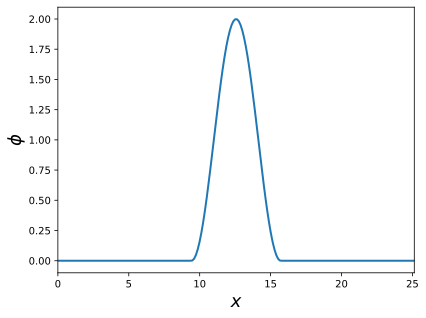

In [6]:
def init_simulation(x_phi,N):
    phi = np.zeros(N)
    phi = 1.+np.cos(x_phi-L/2.)
    xmask = np.where(np.abs(x_phi-L/2.) > np.pi)
    phi[xmask] = 0.
    return phi
phi = init_simulation(x_phi,N)
plt.plot(x_phi,phi,lw=2)
plt.xlabel('$x$', fontdict = font)
plt.ylabel(r'$\phi$', fontdict = font)
plt.xlim(0,L)
plt.show()

A slower but easier to understand version of this function is shown below. The tag slow is explained shortly after.

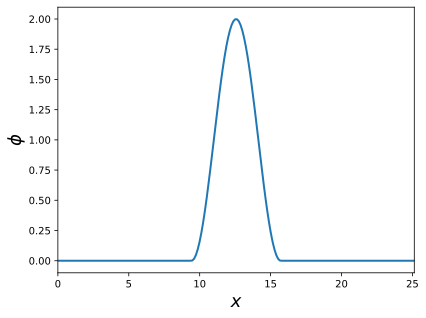

In [7]:
def init_simulation_slow(u,phi,x_phi,N):
    for i in range(N):
        if (np.abs(x_phi[i]-L/2.) > np.pi):
            phi[i] = 0.
        else:
            phi[i] = 1.+np.cos(x_phi[i]-L/2.)
    return phi
phi = init_simulation_slow(u,phi,x_phi,N)
plt.plot(x_phi,phi,lw=2)
plt.xlabel('$x$', fontdict = font)
plt.ylabel(r'$\phi$', fontdict = font)
plt.xlim(0,L)
plt.show()

<h3>Step 3: Code your interpolation/derivativation subroutine</h3>

Before we can simulate our system, we need to write and test our spatial interpolation and derivative procedure. Below we test the speed of two approaches, The first uses a for loop, whereas the second using the rules of indexing in python.

In [8]:

%%timeit 

flux0 = np.zeros(N+1)
for i in range(1,N):
    flux0[i] = 0.5*(phi[i-1]+phi[i])*u[i]




91.1 µs ± 3.85 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [9]:
%%timeit 


flux1 = np.zeros(N+1)
flux1[1:N] = 0.5*(phi[0:N-1]+phi[1:N])*u[1:N]


4.19 µs ± 165 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


The choice for the interpolation is obvious:

In [10]:
def compute_flux(a,v,N):
    f=np.zeros(N+1)
    f[1:N] = 0.5*(a[0:N-1]+a[1:N])*v[1:N]
    f[0] = f[1]
    f[N] = f[N-1]
    return f

<h3>Step 4: Verification</h3>

The interpolation and derivation operations are critical components of the simulation that must be verified. Since the velocity is unity, $F_{i\pm1/2}=\phi_{i\pm1/2}$.

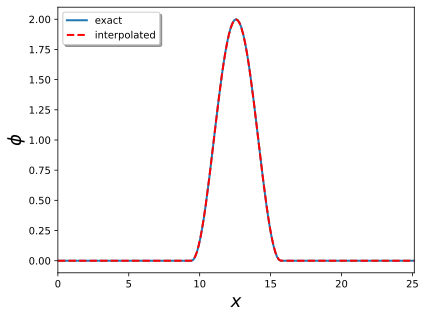

In [11]:
F_exact = np.zeros(N+1)
F_exact = init_simulation(x_u,N+1)
F = compute_flux(phi,u,N)
plt.plot(x_u,F_exact,lw=2,label="exact")
plt.plot(x_u,F,'r--',lw=2,label="interpolated")
plt.xlabel('$x$', fontdict = font)
plt.ylabel(r'$\phi$', fontdict = font)
plt.xlim(0,L)
plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=1, shadow=True, fancybox=True)
plt.show()

Although the plot suggests that the interpolation works, a visual proof can be deceptive. It is best to calculate the error between the exact and interpolated solution. Here we use an $l^2$-norm:
$$
\Vert F\Vert_2=\sqrt{\sum_{i=0}^{N}\left(F_i-F_i^e\right)^2}
$$
where $F_e$ is the exact solution for the flux.

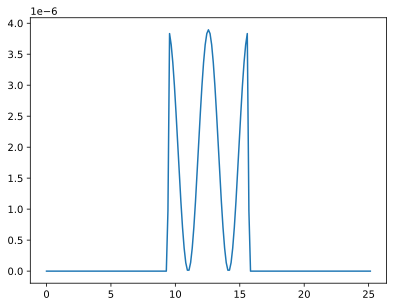

error norm L 2= 9.7672e-03


In [12]:
N = 200
phi = np.zeros(N)
F_exact = np.zeros(N+1)
F = np.zeros(N+1)
u = u_0*np.ones(N+1)
x_phi = np.linspace(dx/2.,L-dx/2.,N)
x_u = np.linspace(0.,L,N+1)
phi = init_simulation(x_phi,N)
F_exact = init_simulation(x_u,N+1)
F = compute_flux(phi,u,N)
error = np.sqrt(np.sum(np.power(F-F_exact,2)))
errorx = np.power(F-F_exact,2)
plt.plot(x_u,errorx)
plt.show()
print('error norm L 2= %1.4e' %error)

error norm L 2= 9.9518e-01
error norm L 2= 3.4142e-02
error norm L 2= 9.7672e-03


<function matplotlib.pyplot.show(close=None, block=None)>

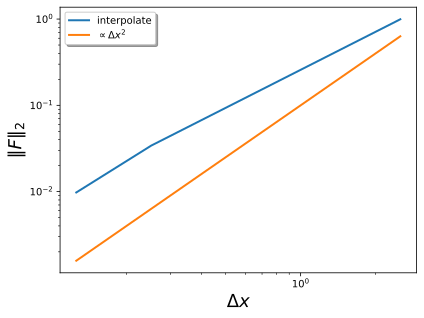

In [15]:
Nerror = 3
Narray = np.array([10, 100, 200])
delta = L/Narray
error = np.zeros(Nerror)
order = np.zeros(Nerror)
for ierror in range(Nerror):
    N = Narray[ierror]
    phi = np.zeros(N)
    F_exact = np.zeros(N+1)
    F = np.zeros(N+1)
    u = u_0*np.ones(N+1)
    x_phi = np.linspace(dx/2.,L-dx/2.,N)
    x_u = np.linspace(0.,L,N+1)
    phi = init_simulation(x_phi,N)
    F_exact = init_simulation(x_u,N+1)
    F = compute_flux(phi,u,N)
    error[ierror] = np.linalg.norm(F-F_exact)
    #error[ierror] = np.sqrt(np.sum(np.power(F-F_exact,2)))
    print('error norm L 2= %1.4e' %error[ierror])
order = 0.1*delta**(2)
plt.loglog(delta,error,lw=2,label='interpolate')
plt.loglog(delta,order,lw=2,label=r'$\propto\Delta x^2$')
plt.legend(loc="upper left", bbox_to_anchor=[0, 1],
           ncol=1, shadow=True, fancybox=True)
plt.xlabel(r'$\Delta x$', fontdict = font)
plt.ylabel(r'$\Vert F\Vert_2$', fontdict = font)
plt.show

For reasons that will become clearer later, we want to consider other interpolation schemes:
$$
\phi_{i+\frac{1}{2}}=g_1\phi_{i+1}-g_2\phi_{i-1}+(1-g_1+g_2)\phi_i
$$
The scheme CS is the interpolation scheme we have used so far. Let us test them all, however we have to modify the interpolation function.

In [22]:
Nscheme = 4
Scheme = np.array(['CS','US1','US2','US3'])
g_1 = np.array([1./2.,0.,0.,3./8.])
g_2 = np.array([0.,0.,1./2.,1./8.])


def compute_flux_advanced(a,v,N,num_scheme):
    imask = np.where(Scheme == num_scheme)
    g1 = g_1[imask][0]
    g2 = g_2[imask][0]
    # print(g1.shape)
    f=np.zeros(N+1)
    f[2:N] = ((1.-g1+g2)*a[1:N-1]+g1*a[2:N]-g2*a[0:N-2])*v[2:N]
    if (num_scheme == 'US2') or (num_scheme == 'US3'):
        f[1] = ((1.-g1)*a[0]+g1*a[1])*v[1]
    f[0] = f[1]
    f[N] = f[N-1]
    return f

table = ListTable()
table.append(['Scheme', '$g_1$', '$g_2$'])
for i in range(4):
    table.append([Scheme[i],g_1[i], g_2[i]])
table

Scheme,$g_1$,$g_2$
CS,0.5,0.0
US1,0.0,0.0
US2,0.0,0.5
US3,0.375,0.125


<function matplotlib.pyplot.show(close=None, block=None)>

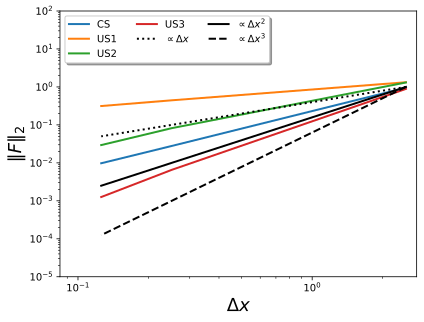

In [23]:
Nerror = 3
Narray = np.array([10, 100, 200])
delta = L/Narray
error = np.zeros((Nerror,Nscheme))
order = np.zeros((Nerror,Nscheme))
for ischeme in range(Nscheme):
    num_scheme = Scheme[ischeme]
    for ierror in range(Nerror):
        N = Narray[ierror]
        dx = L/N
        phi = np.zeros(N)
        F_exact = np.zeros(N+1)
        F = np.zeros(N+1)
        u = u_0*np.ones(N+1)
        x_phi = np.linspace(dx/2.,L-dx/2.,N)
        x_u = np.linspace(0.,L,N+1)
        phi = init_simulation(x_phi,N)
        F_exact = init_simulation(x_u,N+1)
        F = compute_flux_advanced(phi,u,N,num_scheme)
        error[ierror,ischeme] = np.linalg.norm(F-F_exact)
        #print('error norm L 2= %1.4e' %error[ierror,ischeme])

for ischeme in range(Nscheme):
    plt.loglog(delta,error[:,ischeme],lw=2,label=Scheme[ischeme])
order = 1.0*(delta/delta[0])
plt.loglog(delta,order,'k:',lw=2,label=r'$\propto\Delta x$')
order = 1.0*(delta/delta[0])**(2)
plt.loglog(delta,order,'k-',lw=2,label=r'$\propto\Delta x^2$')
order = 1.0*(delta/delta[0])**(3)
plt.loglog(delta,order,'k--',lw=2,label=r'$\propto\Delta x^3$')
plt.legend(loc=2, bbox_to_anchor=[0, 1],
           ncol=3, shadow=True, fancybox=True)
plt.xlabel(r'$\Delta x$', fontdict = font)
plt.ylabel(r'$\Vert F\Vert_2$', fontdict = font)
plt.xlim(L/300,L/9.)
plt.ylim(1e-5,1e2)
plt.show

<h3 style="color:red">Q3: What do you observe? </h3>
<h3 style="color:red">Q4: Write a code to verify the divergence subroutine. </h3>

In [24]:
def flux_divergence(f,N,dx):
    df = np.zeros(N)
    df[0:N] = (f[1:N+1]-f[0:N])/dx
    return df

<h3>Step 5: Writing the simulation code</h3>

The first code solves:
<p class='alert alert-info'>
$$
\phi_i^{n+1}=\phi_i^n-\frac{\Delta t}{\Delta x}\left(F^n_{i+\frac{1}{2}} - F^n_{i-\frac{1}{2}}\right)
$$
</p>
for whatever scheme you choose. Play with the different schemes. Consider that the analytical solution is:
$$
\phi(x,t)=\begin{cases}
1+\cos\left[x-\left(\frac{L}{2}+u_0t\right)\right]&,\text{ for }\left\vert x-\left(\frac{L}{2}+u_0t\right)\right\vert\leq\pi\\
0&,\text{ for }\left\vert x-\left(\frac{L}{2}+u_0t\right)\right\vert>\pi
\end{cases}
$$

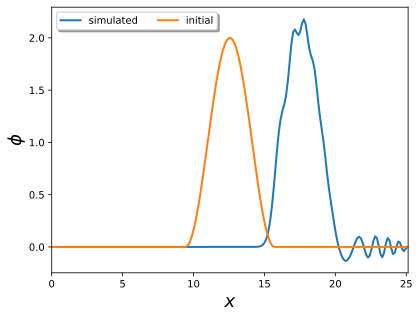

In [25]:
N=200
Simulation_time = 5.
dx = L/N
x_phi = np.linspace(dx/2.,L-dx/2.,N)
x_u = np.linspace(0.,L,N+1)
u_0 = 1.
num_scheme = 'US2'
u = u_0*np.ones(N+1)
phi = np.zeros(N)
flux = np.zeros(N+1)
divflux = np.zeros(N)

phi = init_simulation(x_phi,N)
phi_init = phi.copy()
number_of_iterations = 100
dt = Simulation_time/number_of_iterations

t = 0.
for it in range (number_of_iterations):
    flux = compute_flux_advanced(phi,u,N,num_scheme)
    divflux = flux_divergence(flux,N,dx)
    phi -= dt*divflux
    t += dt
plt.plot(x_phi,phi,lw=2,label='simulated')
plt.plot(x_phi,phi_init,lw=2,label='initial')
plt.legend(loc=2, bbox_to_anchor=[0, 1],
           ncol=2, shadow=True, fancybox=True)
plt.xlabel('$x$', fontdict = font)
plt.ylabel(r'$\phi$', fontdict = font)
plt.xlim(0,L)
plt.show()

The discretization of the time derivative is crude. A better discretization is the 2<sup>nd</sup>-order Runge-Kutta:
<p class='alert alert-info'>
\begin{eqnarray}
\phi_i^{n+1/2}&=&\phi_i^n-\frac{\Delta t}{2}\frac{F^n_{i+\frac{1}{2}} - F^n_{i-\frac{1}{2}}}{\Delta x}\\
\phi_i^{n+1}&=&\phi_i^n-\Delta t\frac{F^{n+1/2}_{i+\frac{1}{2}} - F^{n+1/2}_{i-\frac{1}{2}}}{\Delta x}
\end{eqnarray}
</p>

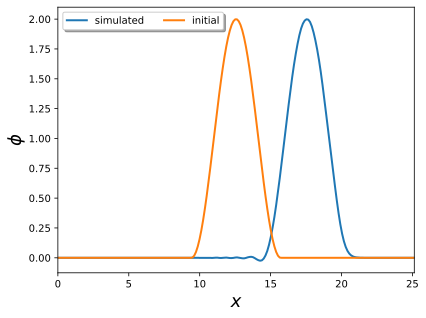

In [26]:
N=200
Simulation_time = 5.
dx = L/N
x_phi = np.linspace(dx/2.,L-dx/2.,N)
x_u = np.linspace(0.,L,N+1)
u_0 = 1.
num_scheme = 'CS'
u = u_0*np.ones(N+1)
phi = np.zeros(N)
flux = np.zeros(N+1)
divflux = np.zeros(N)
phiold = np.zeros(N)

phi = init_simulation(x_phi,N)
phi_init = phi.copy()
rk_coef = np.array([0.5,1.])

number_of_iterations = 100
dt = Simulation_time/number_of_iterations

t = 0.
for it in range (number_of_iterations):
    phiold = phi
    for irk in range(2):
        flux = compute_flux_advanced(phi,u,N,num_scheme)
        divflux = flux_divergence(flux,N,dx)
        phi = phiold-rk_coef[irk]*dt*divflux
    t += dt
plt.plot(x_phi,phi,lw=2,label='simulated')
plt.plot(x_phi,phi_init,lw=2,label='initial')
plt.legend(loc=2, bbox_to_anchor=[0, 1],
           ncol=2, shadow=True, fancybox=True)
plt.xlabel('$x$', fontdict = font)
plt.ylabel(r'$\phi$', fontdict = font)
plt.xlim(0,L)
plt.show()

<h3 style="color:red"> Q5: How do you expect the system evolves in time (based on the analytical solution? Describe what you observe from the simulations in terms of the effect of the numerical schemes.</h3>
If it helps, plot the evolution of the analytical solution in time.